In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import cython

from typing import Tuple
from cython.parallel import prange

In [2]:
%load_ext Cython

In [3]:
# Multiply steps computed from asymptotic behaviour of errors by this.
SAFETY = 0.9

MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
MAX_FACTOR = 10.  # Maximum allowed increase in a step size.

EPS = np.finfo(np.float64).eps

RK23_order = 3
RK23_error_estimator_order = 2
RK23_n_stages = 3
RK23_C = np.array([0, 1 / 2, 3 / 4], order='C')
RK23_A = np.array(
    [
        [0, 0, 0],
        [1 / 2, 0, 0],
        [0, 3 / 4, 0]
        ], order='C'
    )
RK23_B = np.array([2 / 9, 1 / 3, 4 / 9], order='C')
RK23_E = np.array([5 / 72, -1 / 12, -1 / 9, 1 / 8], order='C')
RK23_P = np.array(
    [[1, -4 / 3, 5 / 9],
     [0, 1, -2 / 3],
     [0, 4 / 3, -8 / 9],
     [0, -1, 1]], order='C'
    )

RK45_order = 5
RK45_error_estimator_order = 4
RK45_n_stages = 6
RK45_C = np.array([0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1], order='C')
RK45_A = np.array(
    [
        [0, 0, 0, 0, 0],
        [1 / 5, 0, 0, 0, 0],
        [3 / 40, 9 / 40, 0, 0, 0],
        [44 / 45, -56 / 15, 32 / 9, 0, 0],
        [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0],
        [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]
        ], order='C'
    )
RK45_B = np.array([35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84], order='C')
RK45_E = np.array(
    [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525,
     1 / 40], order='C'
    )
# Corresponds to the optimum value of c_6 from [2]_.
RK45_P = np.array(
    [
        [1, -8048581381 / 2820520608, 8663915743 / 2820520608,
         -12715105075 / 11282082432],
        [0, 0, 0, 0],
        [0, 131558114200 / 32700410799, -68118460800 / 10900136933,
         87487479700 / 32700410799],
        [0, -1754552775 / 470086768, 14199869525 / 1410260304,
         -10690763975 / 1880347072],
        [0, 127303824393 / 49829197408, -318862633887 / 49829197408,
         701980252875 / 199316789632],
        [0, -282668133 / 205662961, 2019193451 / 616988883, -1453857185 / 822651844],
        [0, 40617522 / 29380423, -110615467 / 29380423, 69997945 / 29380423]], order='C'
    )


@njit
def _norm(x):
    return np.linalg.norm(x) / np.sqrt(x.size)

def rk_integrate_py(
    diffeq: callable, t_span: Tuple[float, float], y0: np.ndarray, args: tuple = tuple(),
    rtol: float = 1.e-6, atol: float = 1.e-8,
    max_step: float = np.inf, first_step: float = None,
    rk_method: int = 1, t_eval: np.ndarray = np.empty(0, dtype=np.float64)
    ):
    """ A Numba-safe Rugge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            # TODO NotImplemented 2 = DOP
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """

    # Clean up and interpret inputs
    t_start = t_span[0]
    t_end = t_span[1]
    direction = np.sign(t_end - t_start) if t_end != t_start else 1
    direction_inf = direction * np.inf
    y0 = np.asarray(y0)
    y_size = y0.size
    dtype = y0.dtype
    time_domain = [t_start]
    y_results = y0.reshape(1, y_size)

    # Integrator Status Codes
    #   0  = Running
    #   -1 = Failed
    #   1  = Finished with no obvious issues
    status = 0

    # Determine RK constants
    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_estimator_order
        rk_n_stages = RK23_n_stages
        C = RK23_C
        A = RK23_A
        B = RK23_B
        E = RK23_E
        P = RK23_P
    else:
        # RK45 Method
        rk_order = RK45_order
        error_order = RK45_error_estimator_order
        rk_n_stages = RK45_n_stages
        C = RK45_C
        A = RK45_A
        B = RK45_B
        E = RK45_E
        P = RK45_P

    # Recast some constants into the correct dtype so they can be used with y.
    A = np.asarray(A, dtype=dtype)
    B = np.asarray(B, dtype=dtype)
    E = np.asarray(E, dtype=dtype)

    error_expo = 1. / (error_order + 1.)

    # Check tolerances
    if rtol < 100. * EPS:
        rtol = 100. * EPS

    atol = np.asarray(atol)
    if atol.ndim > 0 and atol.shape != (y_size,):
        # atol must be either the same for all y or must be provided as an array, one for each y.
        raise Exception

    # Initialize variables for start of integration
    t_now = t_start
    y_now = np.asarray(y0)
    dydt_now = np.asarray(diffeq(t_now, y_now, *args), dtype=dtype)
    if first_step is None:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = np.inf
        else:
            scale = atol + np.abs(y_now) * rtol
            d0 = _norm(y_now / scale)
            d1 = _norm(dydt_now / scale)
            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            y1 = y_now + h0 * direction * dydt_now
            t1 = t_now + h0 * direction

            dydt1 = np.asarray(diffeq(t1, y1, *args), dtype=dtype)
            d2 = _norm((dydt1 - dydt_now) / scale) / h0

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = min(100. * h0, h1)
    else:
        if first_step <= 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > np.abs(t_end - t_start):
            # Step size can not exceed bounds
            raise Exception
        step_size = first_step

    # Initialize RK-K variable
    K = np.empty((rk_n_stages + 1, y_size), dtype=dtype)

    # Main integration loop
    message = 'Running...'
    # # Time Loop
    while status == 0:

        if t_now == t_end or y_size == 0:
            t_prev = t_now
            t_now = t_end
            message = 'Finished'
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        min_step = 10. * np.abs(np.nextafter(t_now, direction_inf) - t_now)
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False
        rejected_message = 'Proper step size not found.'
        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                rejected_message = 'Required step size is less than spacing between numbers.'
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_now + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:

                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_now
            step_size = np.abs(step)

            # Calculate derivative using RK method
            K[0] = dydt_now
            s = 1
            for a, c in zip(A[1:], C[1:]):
                K_ = np.ascontiguousarray(K[:s].T)
                a_ = np.ascontiguousarray(a[:s])
                dy = np.dot(K_, a_) * step
                K[s] = np.asarray(diffeq(t_now + c * step, y_now + dy, *args), dtype=dtype)
                s += 1

            y_new = y_now + step * np.dot(K[:-1].T, B)
            dydt_new = np.asarray(diffeq(t_now + step, y_new, *args), dtype=dtype)
            K[-1] = dydt_new

            # Check how well this step performed
            scale = atol + np.maximum(np.abs(y_now), np.abs(y_new)) * rtol
            error_norm = _norm(np.dot(K.T, E) * step / scale)

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                        MAX_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(
                    MIN_FACTOR,
                    SAFETY * error_norm**-error_expo
                    )
                step_rejected = True

        if not step_accepted or step_error:
            # Issue with step convergence
            status = -1
            message = 'Error in step size calculation:\n' + rejected_message
            break

        # End of step loop. Update the _now variables
        t_old = t_now
        y_old = y_now
        dydt_old = dydt_now

        t_now = t_new
        y_now = y_new
        dydt_now = dydt_new

        # Save data
        time_domain.append(t_now)

        # Numba does not support np.stack(x) if x is a list. So we have to continuously hstack as we go.
        y_new_array = y_now.reshape(1, y_size)
        y_results = np.concatenate((y_results, y_new_array))

    time_domain = np.asarray(time_domain, dtype=np.float64)
    # To match the format that scipy follows, we will take the transpose of y.
    y_results = y_results.T

    if t_eval.size > 0:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output, so we must use an interpolation.
        t_eval = np.asarray(t_eval, dtype=np.float64)
        y_results_reduced = np.empty((y_size, t_eval.size), dtype=dtype)

        for i in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            y_results_reduced[i, :] = np.interp(t_eval, time_domain, y_results[i, :])

        y_results = y_results_reduced
        time_domain = t_eval

    success = status == 1

    # Make sure arrays are C-contiguous
    y_results = np.ascontiguousarray(y_results)
    time_domain = np.ascontiguousarray(time_domain)

    return time_domain, y_results, success, message

rk_integrate_nb = njit(rk_integrate_py)

In [51]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
from cython.parallel import parallel, prange
from cpython cimport array
from libc.stdlib cimport malloc, free
np.import_array()

# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9

cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf

cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.

# RK23 Constants
cdef double RK23_C[3]
cdef double complex RK23_B[3]
cdef double complex RK23_E[4]
cdef double complex RK23_A[3][3]
cdef unsigned int RK23_order = 3
cdef unsigned int RK23_error_order = 2
cdef unsigned int RK23_n_stages = 3
RK23_C[:] = [0, 1 / 2, 3 / 4]
cdef unsigned int RK23_LEN_C = 3
RK23_B[:] = [2 / 9, 1 / 3, 4 / 9]
RK23_E[:] = [5 / 72, -1 / 12, -1 / 9, 1 / 8]

RK23_A[0][:] = [0, 0, 0]
RK23_A[1][:] = [1 / 2, 0, 0]
RK23_A[2][:] = [0, 3 / 4, 0]

# RK45 Constants
cdef double RK45_C[6]
cdef double complex RK45_B[6]
cdef double complex RK45_E[7]
cdef double complex RK45_A[6][5]
cdef unsigned int RK45_order = 5
cdef unsigned int RK45_error_order = 4
cdef unsigned int RK45_n_stages = 6
RK45_C[:] = [0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1]
cdef unsigned int RK45_LEN_C = 6
RK45_B[:] = [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84]
RK45_E[:] = [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525, 1 / 40]

RK45_A[0][:] = [0, 0, 0, 0, 0]
RK45_A[1][:] = [1 / 5, 0, 0, 0, 0]
RK45_A[2][:] = [3 / 40, 9 / 40, 0, 0, 0]
RK45_A[3][:] = [44 / 45, -56 / 15, 32 / 9, 0, 0]
RK45_A[4][:] = [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0]
RK45_A[5][:] = [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]


xx = np.empty((1,), dtype=np.float64)

@cython.cdivision(True)
@cython.boundscheck(False)
cdef double _norm(double complex[:] x, unsigned int x_size):
    
    cdef int i
    cdef double size_sqrt, value_abs
    cdef double x_size_float, frobenius_sum
    
    # Initialize summation
    frobenius_sum = 0.
    
    # Find sqrt(size)
    x_size_float = <double>x_size
    size_sqrt = sqrt(x_size)
    
    # Perform summation
    for i in range(x_size):
        value_abs = abs(x[i])
        frobenius_sum += value_abs * value_abs
    
    # Find sqrt-norm
    result = sqrt(frobenius_sum) / size_sqrt
    return result


@cython.cdivision(True)
@cython.boundscheck(False)
# @cython.wraparound(False)
# @cython.nonecheck(False)
def rk_integrate_cy(
    diffeq,
    (double, double) t_span, 
    np.ndarray[np.complex128_t, ndim=1] y0, 
    tuple args = tuple(),
    double rtol = 1.e-6, 
    double atol = 1.e-8,
    double max_step = MAX_STEP, 
    double first_step = 0.,
    unsigned int rk_method = 1,
    np.ndarray[np.float64_t, ndim=1] t_eval = xx
    ):
    """ A Numba-safe Rugge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            # TODO NotImplemented 2 = DOP
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """
    global RK23_C, RK23_B, RK23_E, RK23_A
    global RK45_C, RK45_B, RK45_E, RK45_A
    
    
    complex_type = np.complex128
    float_type = np.float64
    
    cdef unsigned int y_size
    # y-array
    y0 = np.asarray(y0)
    y_size = y0.size
    dtype = y0.dtype
    
    cdef list time_domain_list, y_results_list
    cdef str message, rejected_message
    cdef (unsigned int, unsigned int) K_size, result_size
    cdef bint success, step_accepted, step_rejected, step_error = False
    cdef unsigned int s, i, j, rk_order, error_order, rk_n_stages, rk_n_stages_plus1, len_c, len_t
    cdef int status
    cdef double t_start, t_end, t_delta, t_delta_abs, t_init_step, error_expo, error_norm, \
        direction, h0_direction, d0, d1, h0, h1, step_size, time_, min_step, step_factor, c
    cdef np.ndarray[np.float64_t, ndim=1] scale, time_domain
    cdef np.ndarray[np.complex128_t, ndim=1] y_new, y_old, y_tmp, y_init_step, dydt_new, dydt_old, dydt_init_step, \
        y_now_ovr_scale, dydt_now_ovr_scale, diffeq_out
    cdef np.ndarray[np.complex128_t, ndim=2] y_results, K
    cdef np.ndarray[np.complex128_t, ndim=1] K_tmp
    cdef double[:] scale_view, C
    cdef double complex[:]  y_now_ovr_scale_view, dydt_now_ovr_scale_view, y_init_step_view, y_new_view, \
        y_old_view, dydt_new_view, dydt_old_view, dydt_init_step_view, y_tmp_view, diffeq_out_view, \
        K_tmp_view, B, E
    cdef double complex[:, :] K_view, A
    
    # Clean up and interpret inputs
    # Time Domain
    t_start = t_span[0]
    t_end = t_span[1]
    t_delta = t_end - t_start
    t_delta_abs = abs(t_delta)
    if t_delta >= 0.:
        direction = 1.
    else:
        direction = -1.
    
    # Set flags
    success = False
    step_accepted = False
    step_rejected = False
    step_error = False
    
    # Start storing results with the initial conditions
    time_domain_list = [t_start]
    y_results_list = [y0]
    
    # Initialize arrays
    scale              = np.empty(y_size, dtype=float_type)
    y_now_ovr_scale    = np.empty(y_size, dtype=complex_type)
    dydt_now_ovr_scale = np.empty(y_size, dtype=complex_type)
    y_init_step        = np.empty(y_size, dtype=complex_type)
    y_new              = np.empty(y_size, dtype=complex_type)
    y_old              = np.empty(y_size, dtype=complex_type)
    dydt_new           = np.empty(y_size, dtype=complex_type)
    dydt_old           = np.empty(y_size, dtype=complex_type)
    dydt_init_step     = np.empty(y_size, dtype=complex_type)
    y_tmp              = np.empty(y_size, dtype=complex_type)
    diffeq_out         = np.empty(y_size, dtype=complex_type)
    
    # Setup memoryviews
    scale_view              = scale
    y_now_ovr_scale_view    = y_now_ovr_scale
    dydt_now_ovr_scale_view = dydt_now_ovr_scale
    y_init_step_view        = y_init_step
    y_new_view              = y_new
    y_old_view              = y_old
    dydt_new_view           = dydt_new
    dydt_old_view           = dydt_old
    dydt_init_step_view     = dydt_init_step
    y_tmp_view              = y_tmp
    diffeq_out_view         = diffeq_out

    # Integrator Status Codes
    #   0  = Running
    #   -1 = Failed
    #   1  = Finished with no obvious issues
    status = 0

    # Determine RK constants
    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_order
        rk_n_stages = RK23_n_stages
        C = RK23_C
        A = RK23_A
        B = RK23_B
        E = RK23_E
        len_c = RK23_LEN_C
    else:
        # RK45 Method
        rk_order = RK45_order
        error_order = RK45_error_order
        rk_n_stages = RK45_n_stages
        C = RK45_C
        A = RK45_A
        B = RK45_B
        E = RK45_E
        len_c = RK45_LEN_C
    
    error_expo = 1. / (<double>error_order + 1.)

    # Check tolerances
    if rtol < EPS_100:
        rtol = EPS_100

#     atol_arr = np.asarray(atol, dtype=np.complex128)
#     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
#         # atol must be either the same for all y or must be provided as an array, one for each y.
#         raise Exception

    # Initialize variables for start of integration
    diffeq(
        t_start,
        y0,
        dydt_new,
        *args
    )
    t_old = t_start
    t_new = t_start
    for i in range(y_size):
        dydt_old_view[i] = dydt_new_view[i]
        y_old_view[i] = y0[i]
        y_new_view[i] = y0[i]

    if first_step == 0.:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:
            for i in range(y_size):
                scale_view[i] = atol + abs(y_old_view[i]) * rtol
                y_now_ovr_scale_view[i] = y_old_view[i] / scale_view[i]
                dydt_now_ovr_scale_view[i] = dydt_old_view[i] / scale_view[i]

            d0 = _norm(y_now_ovr_scale_view, y_size)
            d1 = _norm(dydt_now_ovr_scale_view, y_size)
            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            h0_direction = h0 * direction
            t_init_step = t_old + h0_direction
            for i in range(y_size):
                y_init_step_view[i] = y_old_view[i] + h0_direction * dydt_old_view[i]

            diffeq(
                t_init_step,
                y_init_step,
                dydt_init_step,
                *args
            )
            
            for i in range(y_size):
                dydt_now_ovr_scale_view[i] = (dydt_init_step_view[i] - dydt_old_view[i]) / scale_view[i]

            d2 = _norm(dydt_now_ovr_scale_view, y_size) / h0

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = min(100. * h0, h1)
    else:
        if first_step <= 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > t_delta_abs:
            # Step size can not exceed bounds
            raise Exception
        step_size = first_step

    # Initialize RK-K variable
    rk_n_stages_plus1 = rk_n_stages + 1
    K_size = (rk_n_stages_plus1, y_size)
    K = np.zeros(
        K_size,
        dtype=complex_type)
    K_tmp = np.empty(
        y_size,
        dtype=complex_type)
    
    # Setup K memoryviews
    K_view = K
    K_tmp_view = K_tmp

    # Main integration loop
    message = 'Running...'
    # # Time Loop
    len_t = 1  # There is an initial condition provided so the time length is already 1
    while status == 0:

        if t_new == t_end or y_size == 0:
            t_old = t_end
            t_new = t_end
            message = 'Finished'
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        min_step = EPS_10
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False
        rejected_message = 'Proper step size not found.'

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                rejected_message = 'Required step size is less than spacing between numbers.'
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:
                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_old
            step_size = abs(step)

            # Calculate derivative using RK method
            for i in range(y_size):
                K_view[0, i] = dydt_old_view[i]

            for s in range(1, len_c):

                c = C[s]
                time_ = t_new + c * step
                
                # Dot Product (K, a) * step
                for j in range(s):
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_tmp_view[i] = y_old_view[i]

                        y_tmp_view[i] = y_tmp_view[i] + (K_view[j, i] * A[s, j] * step)

                diffeq(
                    time_,
                    y_tmp,
                    diffeq_out,
                    *args
                )
                
                for i in range(y_size):
                    K_view[s, i] = diffeq_out_view[i]
            
            # Dot Product (K, B) * step
            for j in range(rk_n_stages_plus1):                    
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new_view[i] = y_old_view[i]
                    
                    y_new_view[i] = y_new_view[i] + (K_view[j, i] * B[j] * step)

            diffeq(
                t_new + step,
                y_new,
                dydt_new,
                *args
            )
            
            # Dot Product (K, E) * step / scale
            for i in range(y_size):
                # Set last array of the K array.
                K_view[-1, i] = dydt_new_view[i]

                # Check how well this step performed.
                scale_view[i] = atol + max(abs(y_old_view[i]), abs(y_new_view[i])) * rtol

                for j in range(rk_n_stages_plus1):
                    if j == 0:
                        # Initialize
                        K_tmp_view[i] = 0.

                    K_tmp_view[i] = K_tmp_view[i] + (K_view[j, i] * E[j] * step / scale_view[i])

            error_norm = _norm(K_tmp_view, y_size)

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                        MAX_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_norm**-error_expo)
                step_rejected = True

        if not step_accepted or step_error:
            # Issue with step convergence
            status = -1
            message = 'Error in step size calculation:\n' + rejected_message
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        for i in range(y_size):
            y_old_view[i] = y_new_view[i]
            dydt_old_view[i] = dydt_new_view[i]

        # Save data
        len_t += 1
        time_domain_list.append(t_new)

        # Numba does not support np.stack(x) if x is a list. So we have to continuously hstack as we go.
        y_results_list.append(
            y_new.copy()
        )
    
    # Create numpy arrays for the output
    result_size = (y_size, len_t)
    y_results_T = np.empty(result_size, dtype=complex_type, order='C')
    time_domain = np.empty(len_t, dtype=float_type, order='C')
    
    for i in range(len_t):
        for j in range(y_size):
            time_domain[i] = time_domain_list[i]
            y_results_T[j, i] =  y_results_list[i][j]
    

    # To match the format that scipy follows, we will take the transpose of y.
    cdef np.ndarray[np.complex128_t, ndim=2] y_results_reduced
    cdef double complex[:, :] y_results_reduced_view
    
    if t_eval.size > 0:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the actual loop for performance gains.
        y_results_reduced = np.empty((y_size, t_eval.size), dtype=np.complex128)
        y_results_reduced_view = y_results_reduced

        for i in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            hh = np.interp(t_eval, time_domain, y_results_T[i, :])
            y_results_reduced_view[i, :] = hh

        y_results_T = y_results_reduced
        time_domain = t_eval

    if status == 1:
        success = True

    return time_domain, y_results_T, success, message

## Testing

In [6]:
@njit()
def y_diff(t, y):
    
    dy = np.zeros_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    
    return dy

@njit()
def y_diff2(t, y, dy):
    
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]

initial_conds = np.asarray((20., 20.), dtype=np.complex128)
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

def diff_plot(t, y):
    
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    plt.show()

C:\ProgramData\Anaconda3\envs\cyrk\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


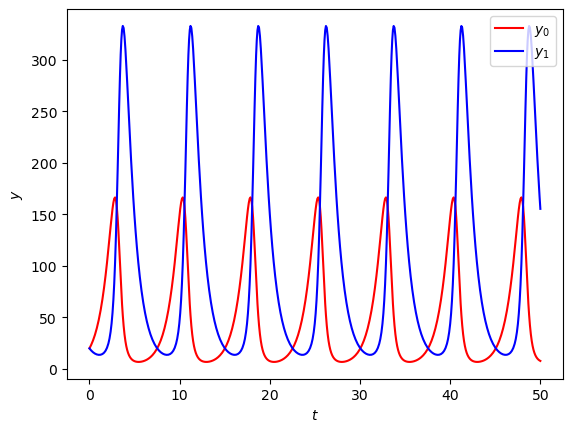

38.2 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
# Test python
time_domain, y_results, success, message = rk_integrate_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit rk_integrate_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\cyrk\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


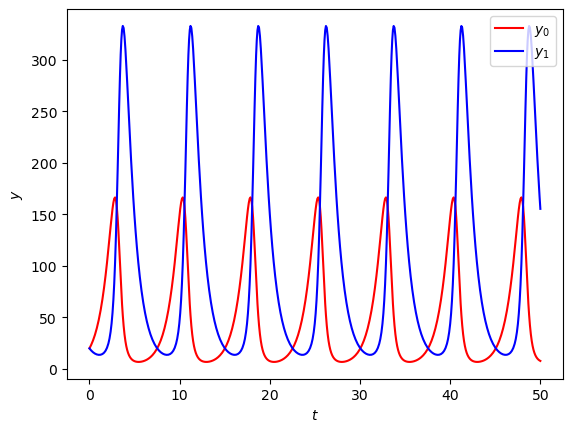

1.97 ms ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
# Test numba
time_domain, y_results, success, message = rk_integrate_nb(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit rk_integrate_nb(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\cyrk\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


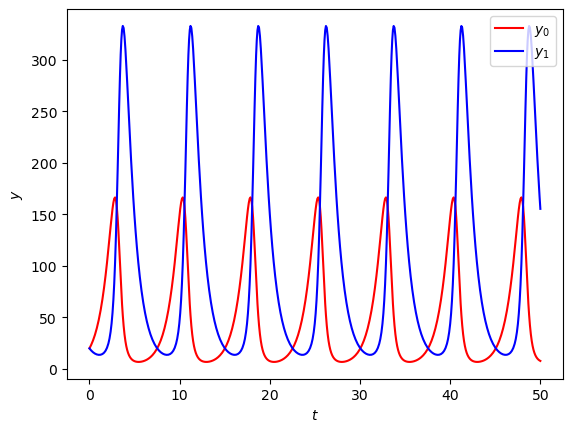

1.94 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
# Test numba v2
rk_integrate_nb2 = njit(rk_integrate_py)
time_domain, y_results, success, message = rk_integrate_nb2(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit rk_integrate_nb2(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

In [32]:
rk_integrate_cy(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol)

(array([0.]),
 array([[20.+0.j],
        [20.+0.j]]),
 False,
 'Error in step size calculation:\nRequired step size is less than spacing between numbers.')

In [23]:
# Test cython
# 60ms
# 53.5ms
# 56.7ms, 56.1ms
# 56.8ms
# 47.8ms
# 36ms
# 35ms
# 26.9ms
# 26.6ms
# started adding mem views and it sucks now. 55ms
# 21.5ms
# 17.6ms
# 17ms
# 16.8ms
# 14.6ms
# 9.16ms
# 8.62ms
# 6.14ms
# 4.41ms
# 4.33ms
# 4.25ms
# 4.1ms
# 4.15ms
# 4.08ms
# 4.07ms
# 3.94ms
# 3.49ms
# 3.43ms
# 3.33ms
# 3.25ms
# 2.96ms
# 2.92ms
# 2.78ms
# 2.55ms
# 2.33ms

time_domain, y_results, success, message = rk_integrate_cy(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol)
print(message)
diff_plot(time_domain, y_results)

%timeit rk_integrate_cy(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol)

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

In [26]:
teval = np.linspace(0., time_span[1], 50)

In [53]:
time_domain, y_results, success, message = rk_integrate_cy(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
print(message)
diff_plot(time_domain, y_results)

# %timeit rk_integrate_cy(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)

TypeError: only length-1 arrays can be converted to Python scalars

C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


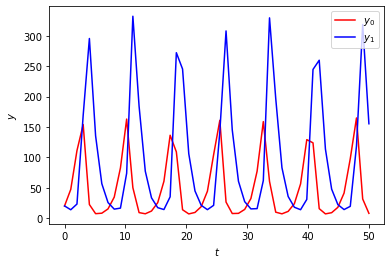

2.63 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
# Test numba
time_domain, y_results, success, message = rk_integrate_nb(y_diff, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
diff_plot(time_domain, y_results)

%timeit rk_integrate_nb(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)